## `dark_current` step

This step removes dark current from a MIRI exposure by subtracting dark current data stored in a dark reference file.

Official documentation for `dark_current` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/dark_current/index.html>


### Input data

An example of running the `dark_current` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public), with precending pipeline steps applied, i.e. `rscd` output.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

Import `dark_current` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.dark_current import dark_current_step

# print the description and options
print(dark_current_step.DarkCurrentStep.__doc__)
print(dark_current_step.DarkCurrentStep.spec)



    DarkCurrentStep: Performs dark current correction by subtracting
    dark current reference data from the input science data model.
    

        dark_output = output_file(default = None) # Dark model or averaged dark subtracted
    


Set the name of the input file and run the step. This will produce an output file ending with `_darkcurrentstep.fits`

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `dark_current` will return the output datamodel so we set this to the `dm` variable.


In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1_rscd_step.fits'

# run the step
dm = dark_current_step.DarkCurrentStep.call(my_input_file, output_use_model=True, save_results=True)


2020-10-29 14:08:43,566 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   Unknown reference type 'pars-darkcurrentstep'
2020-10-29 14:08:43,569 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2020-10-29 14:08:43,649 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_rscd_step.fits',).
2020-10-29 14:08:43,651 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2020-10-29 14:08:43,935 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0049.fits
2020-10-29 14:08:45,678 - stpipe.DarkCurrentStep - INFO - Science data 

We can plot the before and after ramp of a sample pixel

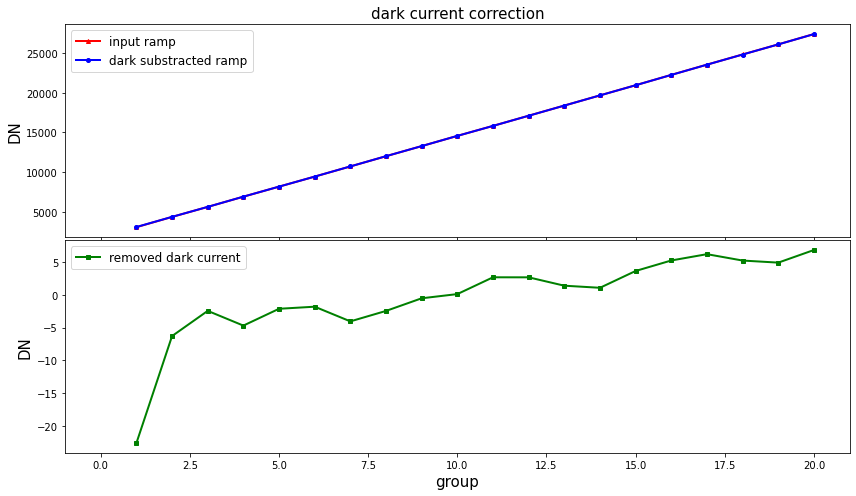

In [4]:
# set the sample pixel
pixel = [600,500]

# define group numbers for integration ramps
group = range(1,dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# open the input file as a datamodel
in_dm = datamodels.open(my_input_file)

# plot
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=4, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', markersize=4, 
            linestyle='-', linewidth=2, label='dark substracted ramp')
axs[0].set_title('dark current correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference which is the removed dark signal
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', 
            marker='s', markersize=4, linestyle='-', linewidth=2, label='removed dark current')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `DarkCurrentStep` class using the `strun` command:

```bash
strun jwst.dark_current.DarkCurrentStep det_image_seq1_MIRIMAGE_F1130Wexp1_rscd_step.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `DarkCurrentStep` using the `strun` command with the associated `dark_current.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/dark_current.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_rscd_step.fits
```

This will produce the same output file ending with `_darkcurrentstep.fits` 


A full list of the command line options are given by running the following:

```bash
strun jwst.dark_current.DarkCurrentStep -h
```

or 

```bash
strun cfgs/dark_current.cfg -h
```


### Override reference file

To override the reference file for this step in Python:

```python
# set the override reference file name
my_ref = 'my_dark.fits'

dm = dark_current.DarkCurrentStep.call(my_input_file, output_use_model=True, save_results=True,
                                       override_dark=my_ref)
```

and using the command line:

```bash
strun jwst.dark_current.DarkCurrentStep det_image_seq1_MIRIMAGE_F1130Wexp1_rscd_step.fits  --override_dark my_dark.fits
```

or

```bash
strun cfgs/dark_current.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_rscd_step.fits --override_dark my_dark.fits
```